# Climatic Overview

**Objective**  
Get an overview of energy-related climatic conditions (temperature, precipitation, and derived indicators) and describe precipitation-driven seasonality for the study area so the EPM modelling focuses on relevant wet/dry periods.
Provide an end-to-end recipe to download ERA5-Land monthly climate variables for the study area, reshape them into modelling tables, and validate spatial/temporal patterns before using them in EPM.

**Data requirements (user-provided) and method**  
- Data requirements: A Climate Data Store (CDS) account with the API key saved in `~/.cdsapirc`, bounding-box coordinates, target variables/months, and a writable output folder.  
- Method: Parameterise the CDS request, pull ERA5-Land NetCDF files with `cdsapi`, convert them to tidy pandas tables, and visualise the resulting series/maps to confirm coverage.

**Overview of steps**  
1. Step 1 - Set the ERA5 request parameters (geography, variables, temporal range, and outputs).  
2. Step 2 - Launch the CDS API download for ERA5-Land monthly data.  
3. Step 3 - Extract the NetCDF batches and format them as CSV-friendly tables.  
4. Step 4 - Plot climate trends and spatial snapshots for sanity checks.  
5. Step 5 - Compare candidate representative grid cells/regions to choose modelling inputs.

> Install `cdsapi` (e.g., `pip install cdsapi`) and register on the [Climate Data Store](https://cds.climate.copernicus.eu/api-how-to) once to obtain your API key.

**Downloading the climate inputs only has to happen once, but for multi-country runs it can take a while (CAPP is roughly 30 minutes). Feel free to start the download and step away—the data will be ready when you return.**


In [1]:
import cdsapi
import timeit
import os
from utils_climatic import *
import xarray as xr
import zipfile
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Toggle inline rendering of figures throughout the notebook
DISPLAY_FIGURES = True  # Set to False to skip displaying figures inline


### Step 1 - Fill in the request parameters

You only need to fill 3 information below to download the data and extract you need.

1. Define the region of interest using ISO A2 codes within the `ISO_A2` list.
2. Specify the start and end years for the data collection.
3. List the variables you want to download from the ERA5-Land dataset in the `variables_list`.

In [2]:
# ISO_A2 = ['AO', 'BI', 'CM', 'CF', 'TD', 'CG', 'CD', 'GQ', 'GA', 'ST']
ISO_A2 = ['AL']  # Bosnia + direct neighbours

dict_rename = {
    'BA': 'Bosnia and Herzegov‡ina',
    'HR': 'Croatia',
    'RS': 'Serbia',
    'ME': 'Montenegro',
    'MK': 'North Macedonia',
    'AL': 'Albania'
}
# ISO_A2 = ['AO', 'BW', 'CD', 'SZ', 'LS', 'MW', 'MZ', 'NA', 'ZA', 'TZ', 'ZM', 'ZW']
start_year, end_year = 2023, 2023                                           # from 1950

variables_list = ['2m_temperature',
                  'total_precipitation'
                 ]# to present year

#### Processing parameters
- Prepare the folder structure
- Data will be downloaded in the `climatic/era5_api` folder
- Extracted data will be saved in the `climatic/era5_extract` folder
- Output data will be saved in the `climatic/output` folder
- Data will be downloaded from the ERA5-Land monthly means dataset

In [3]:

# Create folder structure
folder_input = 'input'
if not os.path.exists(folder_input): os.mkdir(folder_input)
folder_api = os.path.join(folder_input, 'era5_api')
if not os.path.exists(folder_api): os.mkdir(folder_api)
folder_extract = os.path.join(folder_input, 'era5_extract')
if not os.path.exists(folder_extract): os.mkdir(folder_extract)
folder_output = 'output'
if not os.path.exists(folder_output): os.mkdir(folder_output)
folder_output = os.path.join(folder_output, '_'.join(ISO_A2))
if not os.path.exists(folder_output): os.mkdir(folder_output)

# Define the dataset
dataset_name = 'reanalysis-era5-land-monthly-means'# 'reanalysis-era5-land'

# Define the API client variable
variable_name = {
    'total_precipitation': 'tp',
    'surface_runoff': 'sro',
    'runoff': 'ro',
    'snow_depth_water_equivalent': 'sd',
    '2m_temperature': 't2m',
    'potential_evaporation': 'pev',
    'total_evaporation': 'e'
}

#
temp = '_'.join([variable_name[variable] for variable in variables_list])
downloaded_files = {iso: f'{dataset_name}_{iso}_{start_year}_{end_year}_{temp}.zip' for iso in ISO_A2}
downloaded_files = {iso: os.path.join(folder_api, file) for iso, file in downloaded_files.items()}
print(f'Files will be download in: {folder_api}, files: {downloaded_files}')

# Define the bounding box for each ISO A2 code
locations = {iso: get_bbox(iso) for iso in ISO_A2}
print(f'Locations: {locations}')

Files will be download in: input/era5_api, files: {'AL': 'input/era5_api/reanalysis-era5-land-monthly-means_AL_2023_2023_t2m_tp.zip'}
Locations: {'AL': (19.272032511000106, 39.637013245000034, 21.036679321000065, 42.654813538000084)}


### Step 2 - Download ERA5-Land monthly data

By default, the data will be downloaded in the `input/era5_api` folder. If you want to change the folder, please change the `folder_api` variable above.
It will be downloaded as a zip file including `.grib`files. Includes all monthly means for the specified period.


**This step can be long.**

In [4]:
years = [ str(start_year +i ) for i in range(end_year - start_year + 1)]

# Create folder if not exists
if not os.path.exists(folder_api): os.mkdir(folder_api)

for (iso, (long_west, lat_south, long_east, lat_north)) in locations.items():

    downloaded_file = downloaded_files[iso]

    print(f'Processing {iso} with bbox: {long_west}, {lat_south}, {long_east}, {lat_north}')
    if not os.path.exists(downloaded_file):
        print('Process started. Please wait the ending message ... ')
        start = timeit.default_timer()
        c = cdsapi.Client()

        c.retrieve(
            dataset_name,
            {
                #'format': 'netcdf',
                'format': 'grib',
                'product_type': 'monthly_averaged_reanalysis',
                'variable': variables_list,
                'year': years,
                'month': [ '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12' ],
                'time': '00:00',
                'area': [ lat_south, long_west, lat_north, long_east ],
            }, downloaded_file
            )

        stop = timeit.default_timer()
        print('Process completed in ', (stop - start)/60, ' minutes')
    else:
        print('File already exists.')

Processing AL with bbox: 19.272032511000106, 39.637013245000034, 21.036679321000065, 42.654813538000084
Process started. Please wait the ending message ... 


2025-11-25 17:35:44,297 INFO Request ID is 667c2c16-3f49-4a9c-8c75-30fe5e22de82
2025-11-25 17:35:44,345 INFO status has been updated to accepted
2025-11-25 17:35:52,798 INFO status has been updated to running
2025-11-25 17:35:57,941 INFO status has been updated to successful
                                                                                         

Process completed in  0.2604312131831345  minutes


### Step 3 - Extract and format the data

In [5]:
dataset = {}
for iso, downloaded_file in downloaded_files.items():
    print(f'Processing {iso} with file: {downloaded_file}')
    data = extract_data(downloaded_file, step_type=True, extract_to=folder_extract)

    # Calculate resolution and add units
    calculate_resolution_netcdf(data, lat_name='latitude', lon_name='longitude')

    for var in data.data_vars:
        print(f"{var}: {data[var].attrs['units']}")

    # Convert units if necessary
    data = convert_dataset_units(data)

    # Export transformed data to NetCDF for future analysis
    data.to_netcdf(os.path.join(folder_output, f"{ os.path.splitext(os.path.basename(downloaded_file))[0]}.nc"))

    dataset.update({iso: data})


Processing AL with file: input/era5_api/reanalysis-era5-land-monthly-means_AL_2023_2023_t2m_tp.zip
Opening GRIB file: input/era5_extract/reanalysis-era5-land-monthly-means_AL_2023_2023_t2m_tp.grib
Opening GRIB file: input/era5_extract/reanalysis-era5-land-monthly-means_AL_2023_2023_t2m_tp.grib
Spatial resolution: 0.10005882352941242° lon x -0.10000000000000142° lat
Approximate spatial resolution:
8.36 km (lon_name) x -11.10 km (lat_name) at 41.14° lat
Temporal resolution: 31 days
t2m: K


In [6]:
downloaded_file

'input/era5_api/reanalysis-era5-land-monthly-means_AL_2023_2023_t2m_tp.zip'

### Step 4 - Visualise climate data

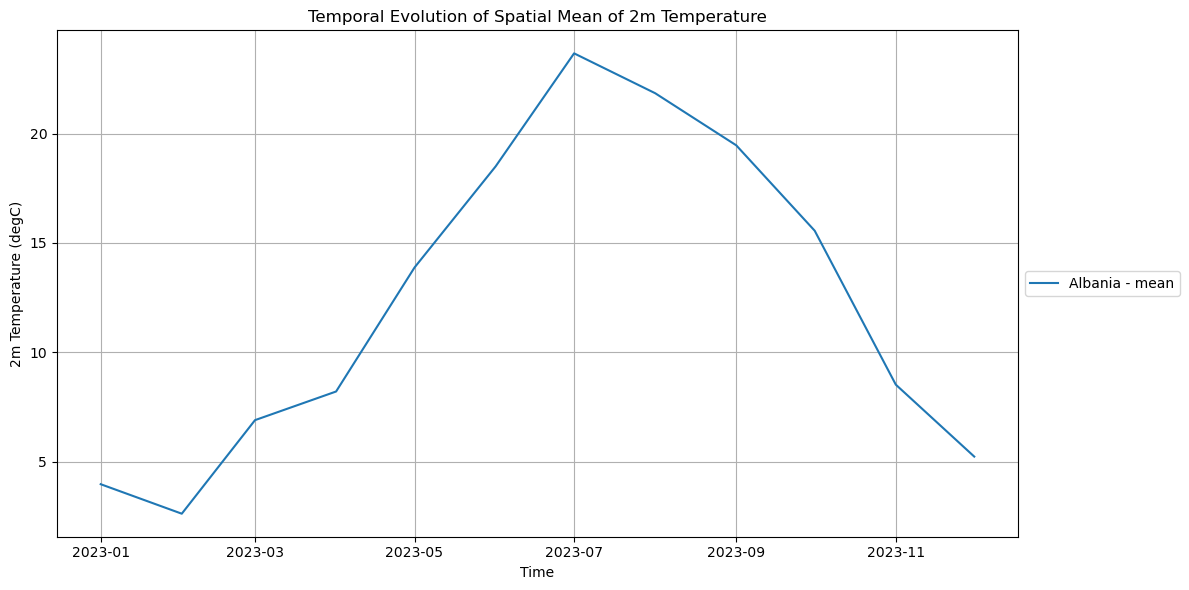

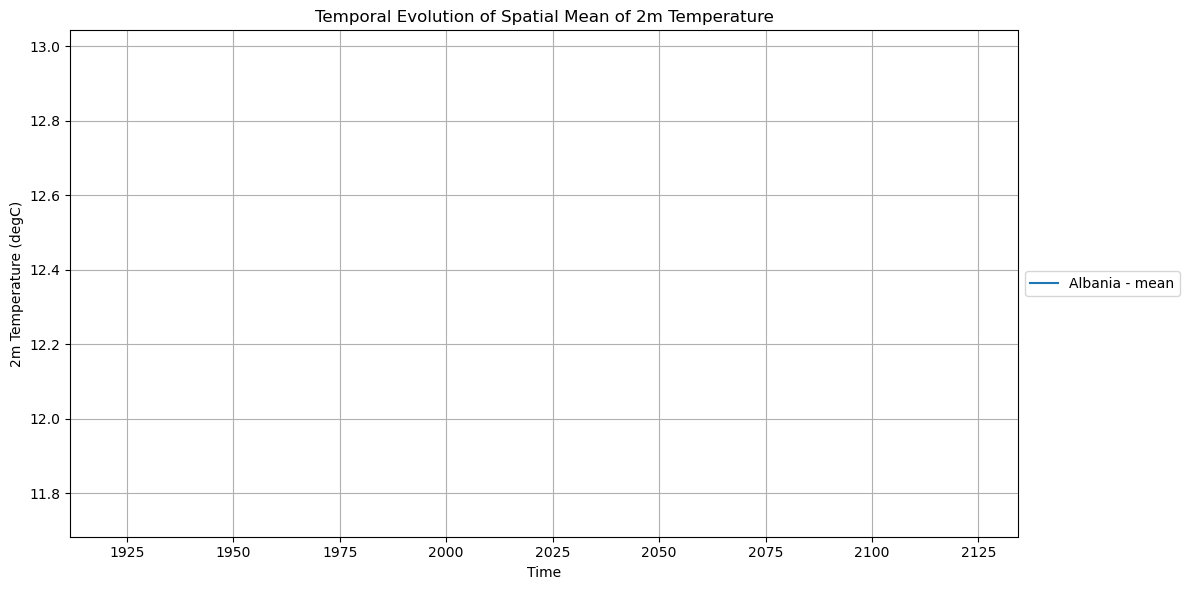

KeyError: "No variable named 'tp'. Did you mean one of ('step',)?"

<Figure size 1200x600 with 0 Axes>

In [7]:
# Plotting spatial mean timeseries for all variables
plot_label_map = {iso: dict_rename.get(iso, iso) for iso in dataset.keys()}
var_display_names = {
    't2m': '2m Temperature',
    'tp': 'Total Precipitation'
}

for var in variables_list:
    selected_var = variable_name.get(var, var)
    display_name = var_display_names.get(selected_var, selected_var.replace('_', ' ').title())
    # Find the indirect from the variable name
    plot_spatial_mean_timeseries_all_iso(
        dataset,
        var=selected_var,
        folder=folder_output,
        display=DISPLAY_FIGURES,
        label_map=plot_label_map,
        var_display_name=display_name
    )

    if var == '2m_temperature':
        agg = 'avg'
    elif var == 'total_precipitation':
        agg = 'sum'
    else:
        agg = None

    plot_spatial_mean_timeseries_all_iso(
        dataset,
        var=selected_var,
        agg=agg,
        folder=folder_output,
        display=DISPLAY_FIGURES,
        label_map=plot_label_map,
        var_display_name=display_name
    )

# Plotting scatter plot of annual spatial means
scatter_annual_spatial_means(
    dataset,
    var_x='t2m',
    var_y='tp',
    folder=folder_output,
    display=DISPLAY_FIGURES,
    label_map=plot_label_map,
    var_x_display=var_display_names.get('t2m'),
    var_y_display=var_display_names.get('tp')
)

# Plotting monthly average for each variable
plot_monthly_mean(
    dataset,
    "t2m",
    lat_name='latitude',
    lon_name='longitude',
    folder=folder_output,
    display=DISPLAY_FIGURES,
    label_map=plot_label_map,
    var_display_name=var_display_names.get('t2m')
)
plot_monthly_mean(
    dataset,
    "tp",
    lat_name='latitude',
    lon_name='longitude',
    folder=folder_output,
    display=DISPLAY_FIGURES,
    label_map=plot_label_map,
    var_display_name=var_display_names.get('tp')
)

# Plotting monthly climatology for each variable
for iso, data in dataset.items():
    print(f'Processing {dict_rename.get(iso, iso)}')
    plot_monthly_climatology_grid(
        data,
        "t2m",
        filename=os.path.join(folder_output, f'monthly_climatology_{iso}_{var}.pdf'),
        display=DISPLAY_FIGURES,
        var_display_name=var_display_names.get('t2m')
    )
    plot_monthly_climatology_grid(
        data,
        "tp",
        filename=os.path.join(folder_output, f'monthly_climatology_{iso}_{var}.pdf'),
        display=DISPLAY_FIGURES,
        var_display_name=var_display_names.get('tp')
    )


### Step 5 - Check representative regions

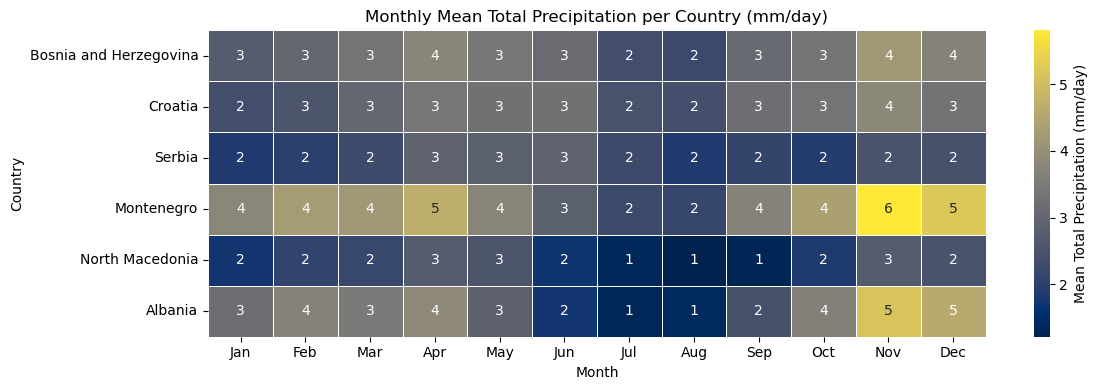

In [ ]:

plot_monthly_precipitation_heatmap(
    dataset,
    path=os.path.join(folder_output, 'monthly_precipitation_heatmap.png'),
    display=DISPLAY_FIGURES,
    label_map=plot_label_map,
    var_display_name=var_display_names.get('tp')
)
